In [1]:
"""New York Stock Exchange
S&P 500 companies historical prices with fundamental data
Last Updated: 5 years ago (Version 3)

About this Dataset
Context
This dataset is a playground for fundamental and technical analysis. It is said that 30% of traffic on stocks is already generated by machines, can trading be fully automated? If not, there is still a lot to learn from historical data.

Content
Dataset consists of following files:

prices.csv: raw, as-is daily prices. Most of data spans from 2010 to the end 2016, for companies new on stock market date range is shorter. There have been approx. 140 stock splits in that time, this set doesn't account for that.
prices-split-adjusted.csv: same as prices, but there have been added adjustments for splits.
securities.csv: general description of each company with division on sectors
fundamentals.csv: metrics extracted from annual SEC 10K fillings (2012-2016), should be enough to derive most of popular fundamental indicators.
Acknowledgements
Prices were fetched from Yahoo Finance, fundamentals are from Nasdaq Financials, extended by some fields from EDGAR SEC databases.

Inspiration
Here is couple of things one could try out with this data:

One day ahead prediction: Rolling Linear Regression, ARIMA, Neural Networks, LSTM
Momentum/Mean-Reversion Strategies
Security clustering, portfolio construction/hedging
Which company has biggest chance of being bankrupt? Which one is undervalued (how prices behaved afterwards), 
what is Return on Investment?"""

"New York Stock Exchange\nS&P 500 companies historical prices with fundamental data\nLast Updated: 5 years ago (Version 3)\n\nAbout this Dataset\nContext\nThis dataset is a playground for fundamental and technical analysis. It is said that 30% of traffic on stocks is already generated by machines, can trading be fully automated? If not, there is still a lot to learn from historical data.\n\nContent\nDataset consists of following files:\n\nprices.csv: raw, as-is daily prices. Most of data spans from 2010 to the end 2016, for companies new on stock market date range is shorter. There have been approx. 140 stock splits in that time, this set doesn't account for that.\nprices-split-adjusted.csv: same as prices, but there have been added adjustments for splits.\nsecurities.csv: general description of each company with division on sectors\nfundamentals.csv: metrics extracted from annual SEC 10K fillings (2012-2016), should be enough to derive most of popular fundamental indicators.\nAcknowle

In [2]:
#Import Libraries
# Pandas allows importing data from various file formats such as comma-separated values, SQL, Microsoft Excel. 
import pandas as pd
# numpy perform a number of mathematical operations
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import itertools as itt
#from pmdarima.arima import ndiffs,nsdiffs
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMA
from sklearn import metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [3]:
# Importing dataset

data = pd.read_csv("prices-split-adjusted.csv")
df = pd.DataFrame(data)

In [4]:
df.head()

,date,symbol,open,close,low,high,volume
0,2016-01-05,WLTW,123.430000,125.839996,122.309998,126.250000,2163600.0
1,2016-01-06,WLTW,125.239998,119.980003,119.940002,125.540001,2386400.0
2,2016-01-07,WLTW,116.379997,114.949997,114.930000,119.739998,2489500.0
3,2016-01-08,WLTW,115.480003,116.620003,113.500000,117.440002,2006300.0
4,2016-01-11,WLTW,117.010002,114.970001,114.089996,117.330002,1408600.0


In [5]:
# Data Information
df.describe()

,open,close,low,high,volume
count,851264.000000,851264.000000,851264.000000,851264.000000,8.512640e+05
mean,64.993618,65.011913,64.336541,65.639748,5.415113e+06
std,75.203893,75.201216,74.459518,75.906861,1.249468e+07
min,1.660000,1.590000,1.500000,1.810000,0.000000e+00
25%,31.270000,31.292776,30.940001,31.620001,1.221500e+06
50%,48.459999,48.480000,47.970001,48.959999,2.476250e+06
75%,75.120003,75.139999,74.400002,75.849998,5.222500e+06
max,1584.439941,1578.130005,1549.939941,1600.930054,8.596434e+08


In [6]:
# showing column wise %ge of NaN values they contains 

for i in df.columns:
  print(i,"\t-\t", df[i].isna().mean()*100)

date 	-	 0.0
symbol 	-	 0.0
open 	-	 0.0
close 	-	 0.0
low 	-	 0.0
high 	-	 0.0
volume 	-	 0.0


#### Since there is no null values, we can move further

In [8]:
df = df[df['symbol']=='AAP']   # Choosin stock values for any company 
df

,date,symbol,open,close,low,high,volume
253,2010-01-04,AAP,40.700001,40.380001,40.360001,41.040001,1701700.0
720,2010-01-05,AAP,40.299999,40.139999,39.720001,40.310001,1932400.0
1188,2010-01-06,AAP,40.049999,40.490002,40.049999,40.779999,1406200.0
1656,2010-01-07,AAP,39.549999,40.480000,39.549999,40.540001,1256800.0
2124,2010-01-08,AAP,40.250000,40.639999,40.110001,40.820000,960300.0
...,...,...,...,...,...,...,...
848766,2016-12-23,AAP,170.690002,170.889999,170.000000,172.080002,334200.0
849266,2016-12-27,AAP,170.720001,171.839996,170.720001,172.750000,508700.0
849766,2016-12-28,AAP,172.009995,170.419998,170.350006,172.929993,357100.0
850266,2016-12-29,AAP,170.080002,170.279999,169.460007,171.080002,431400.0


In [9]:
df.head()

,date,symbol,open,close,low,high,volume
253,2010-01-04,AAP,40.700001,40.380001,40.360001,41.040001,1701700.0
720,2010-01-05,AAP,40.299999,40.139999,39.720001,40.310001,1932400.0
1188,2010-01-06,AAP,40.049999,40.490002,40.049999,40.779999,1406200.0
1656,2010-01-07,AAP,39.549999,40.480000,39.549999,40.540001,1256800.0
2124,2010-01-08,AAP,40.250000,40.639999,40.110001,40.820000,960300.0


In [10]:
# Prepare index for date column & see the first five rows of given dataset
df.index = pd.DatetimeIndex(df.date)
df=df.drop(columns='date')
df.head()

,symbol,open,close,low,high,volume
date,,,,,,
2010-01-04,AAP,40.700001,40.380001,40.360001,41.040001,1701700.0
2010-01-05,AAP,40.299999,40.139999,39.720001,40.310001,1932400.0
2010-01-06,AAP,40.049999,40.490002,40.049999,40.779999,1406200.0
2010-01-07,AAP,39.549999,40.480000,39.549999,40.540001,1256800.0
2010-01-08,AAP,40.250000,40.639999,40.110001,40.820000,960300.0


In [11]:
df.tail()

,symbol,open,close,low,high,volume
date,,,,,,
2016-12-23,AAP,170.690002,170.889999,170.000000,172.080002,334200.0
2016-12-27,AAP,170.720001,171.839996,170.720001,172.750000,508700.0
2016-12-28,AAP,172.009995,170.419998,170.350006,172.929993,357100.0
2016-12-29,AAP,170.080002,170.279999,169.460007,171.080002,431400.0
2016-12-30,AAP,171.320007,169.119995,168.600006,172.000000,489300.0


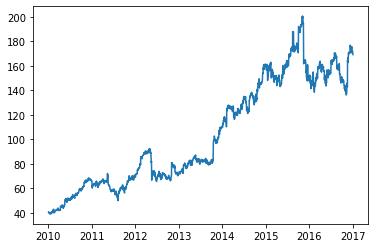

In [12]:
plt.plot(df.index,df['close'])
plt.show()

### Visualization

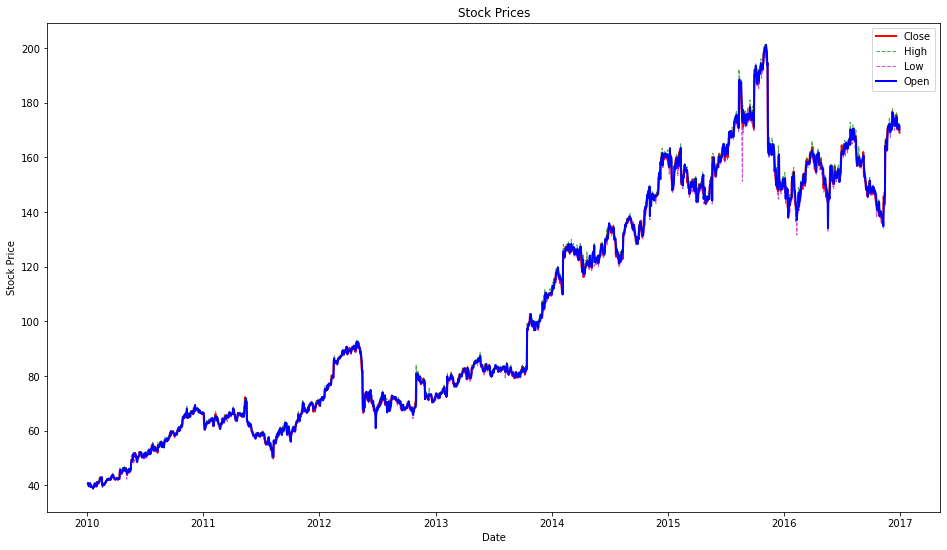

In [13]:
#creates a plotting area in a figure with respect to all features i.e. close, open,high, low, etc.
plt.figure(figsize=(16,9))

plt.plot(df.index, df.close, lw=2, color='r',label='Close')
plt.plot(df.index, df.high, lw=1, color='g',linestyle='--',alpha=0.7,label='High')
plt.plot(df.index, df.low, lw=1, color='m',linestyle='--',alpha=0.7,label='Low')
plt.plot(df.index, df.open, lw=2, color='b',label='Open')

plt.legend()
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Stock Prices')
plt.show()

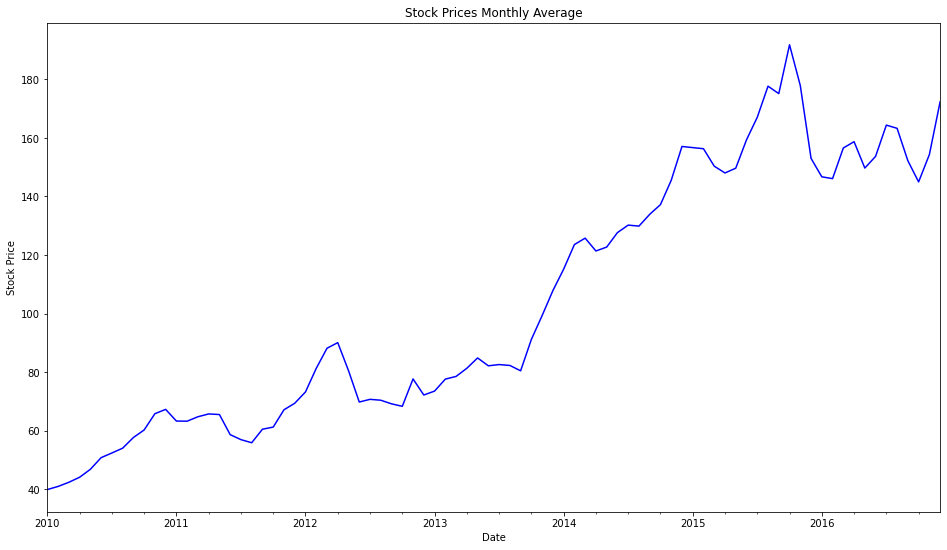

In [15]:
# lects see the relation between date & Opening Price of the stock
df_open_month_avg = df['open'].resample('MS').mean()

plt.figure(figsize=(16,9))

df_open_month_avg.plot(color='b')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Stock Prices Monthly Average')

plt.show()

## Search Seasonality for SARIMA

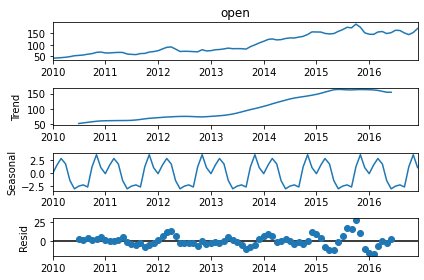

In [54]:
S = seasonal_decompose(df_open_month_avg,model='add')
S.plot()
plt.show()

In [55]:
def adf_test(timeseries):
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

print(adf_test(df_open_month_avg))

Results of Dickey-Fuller Test:
Test Statistic                 -0.616754
p-value                         0.867151
#Lags Used                      2.000000
Number of Observations Used    81.000000
Critical Value (1%)            -3.513790
Critical Value (5%)            -2.897943
Critical Value (10%)           -2.586191
dtype: float64
None


Results of Dickey-Fuller Test:
Test Statistic                -6.474491e+00
p-value                        1.341650e-08
#Lags Used                     1.000000e+00
Number of Observations Used    8.100000e+01
Critical Value (1%)           -3.513790e+00
Critical Value (5%)           -2.897943e+00
Critical Value (10%)          -2.586191e+00
dtype: float64
None


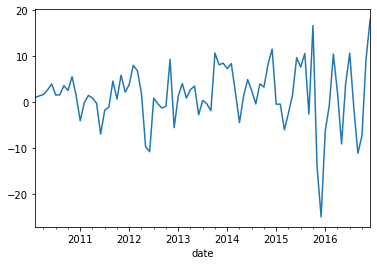

In [56]:
df_open_t_adj = df_open_month_avg - df_open_month_avg.shift(1)
df_open_t_adj = df_open_t_adj.dropna()
df_open_t_adj.plot()

print(adf_test(df_open_t_adj))

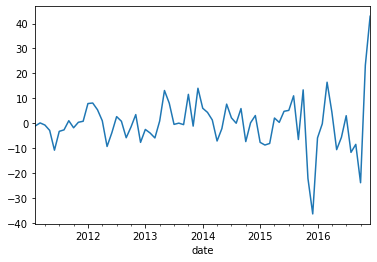

In [57]:
df_open_s_adj = df_open_t_adj - df_open_t_adj.shift(12)
df_open_s_adj = df_open_s_adj.dropna()
df_open_s_adj.plot()
plt.show()

#### Autocorrelation & Partial Autocorrelation

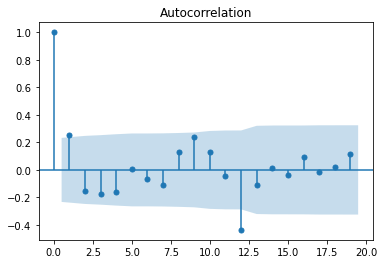

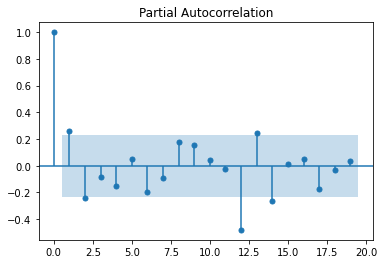

In [58]:
plot_acf(df_open_s_adj)
plt.show()
plot_pacf(df_open_s_adj)
plt.show()

In [59]:
import warnings
p = range(0, 3)
d = range(1,2)
q = range(0, 3)
pdq = list(itt.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itt.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

params=[]
params_seasonal=[]
AIC = []
for param in pdq:
    for param_seasonal in seasonal_pdq:
         with warnings.catch_warnings():
            warnings.filterwarnings("ignore")
            try:
                mod = SARIMAX(df_open_month_avg,
                              order=param,
                              seasonal_order=param_seasonal,
                              enforce_stationarity=False,
                              enforce_invertibility=False)
                results = mod.fit()
                if results.aic > 50:
                    params.append(param)
                    params_seasonal.append(param_seasonal)
                    AIC.append(results.aic)
                    
            except:
                continue
GS_params = pd.DataFrame(list(zip(params,params_seasonal,AIC)))
Best_params=GS_params.loc[GS_params[2].idxmin()]
print('Best Parameters had been: ARIMA{0}x{1} - AIC:{2}'.format(Best_params[0],Best_params[1],Best_params[2]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 1, 1) x (0, 1, 1, 12)
SARIMAX: (0, 1, 1) x (0, 1, 2, 12)
SARIMAX: (0, 1, 2) x (1, 1, 0, 12)
SARIMAX: (0, 1, 2) x (1, 1, 1, 12)
Best Parameters had been: ARIMA(0, 1, 2)x(1, 1, 2, 12) - AIC:321.4741668514296


In [60]:
series_to_pred =df_open_month_avg

y_index = series_to_pred.index

date_train = int(len(y_index)*0.9)

y_train = series_to_pred[y_index[:date_train]]
y_test = series_to_pred[y_index[date_train:len(y_index)]]

series_to_pred = series_to_pred.asfreq('MS')
y_train= y_train.asfreq('MS')
y_test= y_test.asfreq('MS')

y_train.tail()

date
2015-11-01    177.887501
2015-12-01    153.020909
2016-01-01    146.714211
2016-02-01    146.090000
2016-03-01    156.557272
Freq: MS, Name: open, dtype: float64

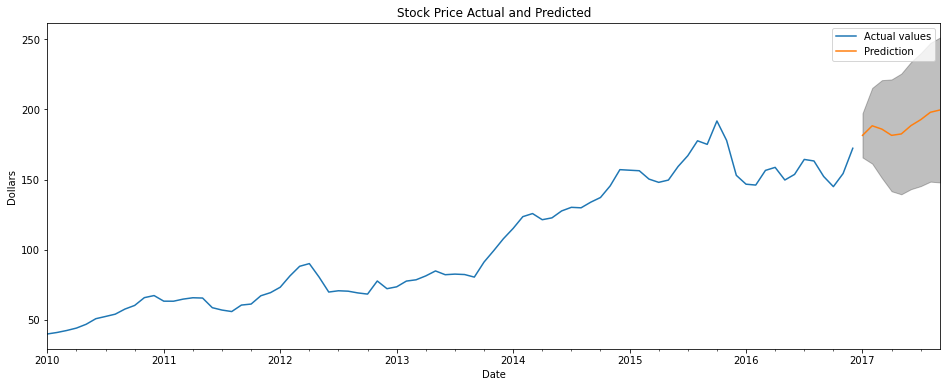

In [61]:
pred_uc = results.get_forecast(steps = len(y_test), dynamic=True)
pred_ci = pred_uc.conf_int()

ax = series_to_pred.plot(label = 'Actual values', figsize = (16, 6))

pred_uc.predicted_mean.plot(ax = ax, label = 'Prediction')

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color = 'k', alpha = .25)

ax.set_xlabel('Date')
ax.set_ylabel('Dollars')
ax.set_title('Stock Price Actual and Predicted')

plt.legend()
plt.show()

In [62]:
y_pred = pred_ci.iloc[:, 0]
y_test=y_test.fillna(np.mean(y_test))
rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
print("The ARIMA model with paremeters {}x{}, has given an rmse in test of {}".format((0,1,2), (0,1,2,12),round(rmse, 2)))

The ARIMA model with paremeters (0, 1, 2)x(0, 1, 2, 12), has given an rmse in test of 14.85


##### RMSE values between 0.2 and 0.5 shows that the model can relatively predict the data accurately but here we are getting 14.85, so this model is not perfect for prediction.

## Using Exponential Smoothing

In [63]:
import numpy
y = df['volume'].resample("M").mean()

In [64]:
print(y.shape)
y

(84,)


date
2010-01-31    1.359921e+06
2010-02-28    1.878674e+06
2010-03-31    1.524270e+06
2010-04-30    1.407295e+06
2010-05-31    1.803990e+06
                  ...     
2016-08-31    1.128939e+06
2016-09-30    1.126567e+06
2016-10-31    8.763524e+05
2016-11-30    1.532714e+06
2016-12-31    7.316524e+05
Freq: M, Name: volume, Length: 84, dtype: float64

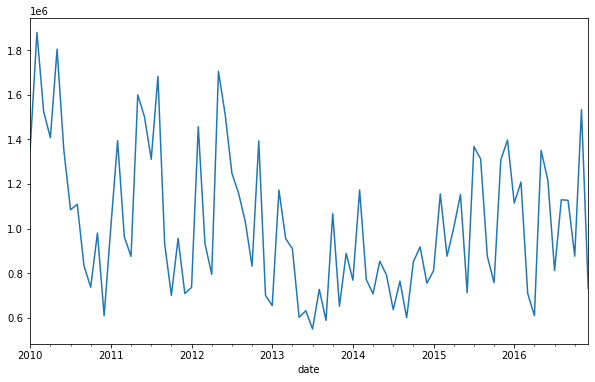

In [65]:
y.plot(figsize=(10, 6))
plt.show()

In [66]:
train=y.loc[:'2015-12-31']
print(train.shape)
train.tail()

(72,)


date
2015-08-31    1.311681e+06
2015-09-30    8.748667e+05
2015-10-31    7.578182e+05
2015-11-30    1.307815e+06
2015-12-31    1.396818e+06
Freq: M, Name: volume, dtype: float64

In [67]:
test=y.loc['2016-01-31':]
print(test.shape)
test.tail()

(12,)


date
2016-08-31    1.128939e+06
2016-09-30    1.126567e+06
2016-10-31    8.763524e+05
2016-11-30    1.532714e+06
2016-12-31    7.316524e+05
Freq: M, Name: volume, dtype: float64

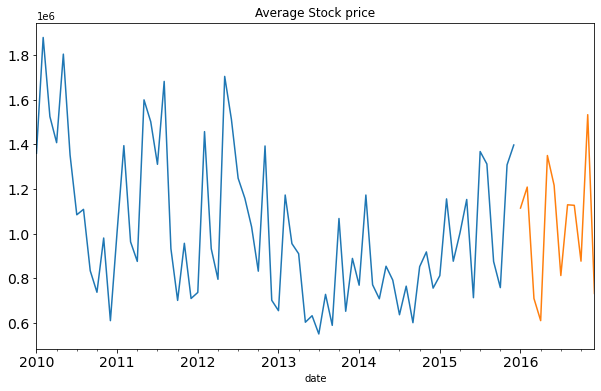

In [68]:
#Plotting data
train.plot(figsize=(10,6), title= 'Average Stock price', fontsize=14)
test.plot(figsize=(10,6), title= 'Average Stock price', fontsize=14)
plt.show()

C:\Users\Paresh\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


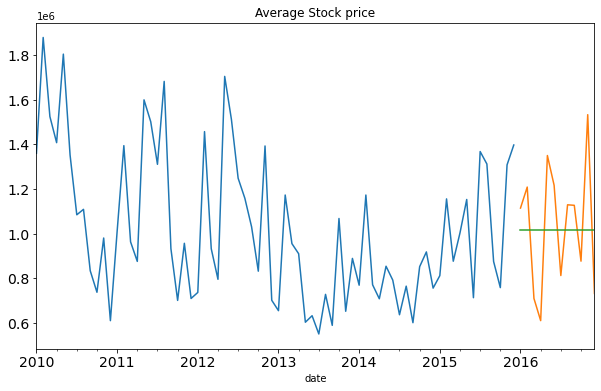

In [69]:
from statsmodels.tsa.api import SimpleExpSmoothing
Exp_Smooth = test.copy()
#smoothing level=alpha
#alpha value should be in the range of 0 to 1.
#values close to 0 indicate that older values are very less imp compared to the recent values
#values close to 1 indicate that older values are equally imp
fit1 = SimpleExpSmoothing(train).fit(smoothing_level=0.01)
Exp_Smooth['SES'] = fit1.forecast(steps=len(test))

train.plot(figsize=(10,6), title= 'Average Stock price', fontsize=14)
test.plot(figsize=(10,6), title= 'Average Stock price', fontsize=14)
Exp_Smooth['SES'].plot(figsize=(10,6), title= 'Average Stock price', fontsize=14)
plt.show()

In [70]:
#AIC is used to compare different models with same Algo but different data/parameters
#choose the model with lowest AIC value
fit1.aic

1833.643377632899

In [71]:
#RMSE is used to compare different models with same data but different Algos
#choose the model with lowest RMSE value
from sklearn.metrics import mean_squared_error
from math import sqrt
rms = sqrt(mean_squared_error(test, Exp_Smooth.SES))
print(rms)

272584.8935809939


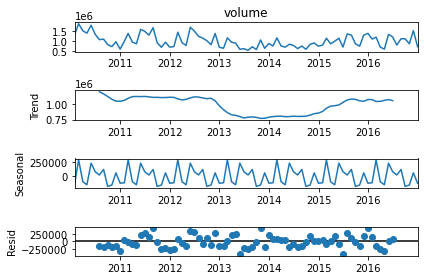

In [72]:
import statsmodels.api as sm
decomposition = sm.tsa.seasonal_decompose(y)
fig = decomposition.plot()
plt.show()

##### use Holt Winter smoothing technique which allows us to include seasonality while making the prediction along with the trend

C:\Users\Paresh\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
<ipython-input-73-30ea17e87b2d>:4: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead
  fit1 = Holt(train).fit(smoothing_level = 0.01,smoothing_slope = 0.25)


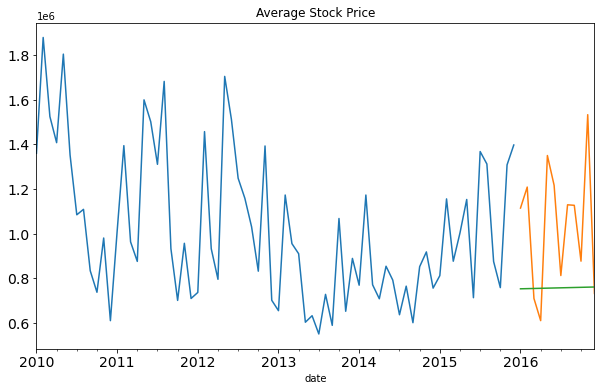

In [73]:
from statsmodels.tsa.api import Holt
Holt_df = test.copy()
#soothing slope=beta
fit1 = Holt(train).fit(smoothing_level = 0.01,smoothing_slope = 0.25)
Holt_df['Holt_linear'] = fit1.forecast(steps=len(test))

train.plot(figsize=(10,6), title= 'Average Stock Price', fontsize=14)
test.plot(figsize=(10,6), title= 'Average Stock Price', fontsize=14)
Holt_df['Holt_linear'].plot(figsize=(10,6), title= 'Average Stock Price', fontsize=14)
plt.show()

In [74]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rms = sqrt(mean_squared_error(test,Holt_df['Holt_linear'] ))
print(rms)

388828.3893632391


C:\Users\Paresh\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
C:\Users\Paresh\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


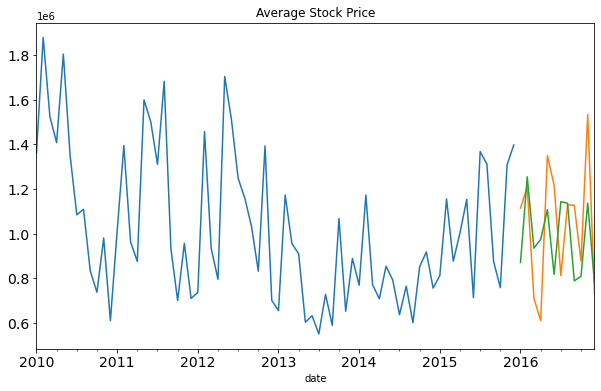

In [75]:
from statsmodels.tsa.api import ExponentialSmoothing
Holt_Winter_df = test.copy()
#seasonalperiods=gamma
fit1 = ExponentialSmoothing(train ,seasonal_periods=12,
                            trend='add',
                            seasonal='add').fit()
Holt_Winter_df['Holt_Winter'] = fit1.forecast(steps=len(test))

train.plot(figsize=(10,6), title= 'Average Stock Price', fontsize=14)
test.plot(figsize=(10,6), title= 'Average Stock Price', fontsize=14)
Holt_Winter_df['Holt_Winter'].plot(figsize=(10,6), title= 'Average Stock Price', fontsize=14)
plt.show()

In [76]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rms = sqrt(mean_squared_error(test, Holt_Winter_df['Holt_Winter']))
print(rms)

266432.48634450283


In [77]:
#pip install pmdarima or pip install pmdarima--user
import pmdarima as pm
model = pm.auto_arima(y,start_p=0, max_p=3, d=None, max_d=2,start_q=0, max_q=3,
start_P=0,max_P=3, D=None, max_D=2, start_Q=0, max_Q=3,
max_order=10, m=12, seasonal=True, information_criterion='aic',
test='adf',trace=True,random_state=10)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=2372.936, Time=0.05 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=2358.792, Time=0.15 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=2358.736, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=2573.158, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=2363.133, Time=0.03 sec
 ARIMA(0,0,1)(1,0,1)[12] intercept   : AIC=2360.286, Time=0.25 sec
 ARIMA(0,0,1)(0,0,2)[12] intercept   : AIC=2357.948, Time=0.17 sec
 ARIMA(0,0,1)(1,0,2)[12] intercept   : AIC=2359.766, Time=0.59 sec
 ARIMA(0,0,1)(0,0,3)[12] intercept   : AIC=2359.124, Time=0.30 sec
 ARIMA(0,0,1)(1,0,3)[12] intercept   : AIC=2360.999, Time=0.43 sec
 ARIMA(0,0,0)(0,0,2)[12] intercept   : AIC=2366.932, Time=0.09 sec
 ARIMA(1,0,1)(0,0,2)[12] intercept   : AIC=2355.637, Time=0.19 sec
 ARIMA(1,0,1)(0,0,1)[12] intercept   : AIC=2357.777, Time=0.10 sec
 ARIMA(1,0,1)(1,0,2)[12] intercept   : AIC=2354.846, Time=1.13 sec
 ARIMA(1,0,1)(1,0,1

In [78]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
model = SARIMAX(y,
                order=(3,2,0),seasonal_order=(1,1,0,12)).fit()

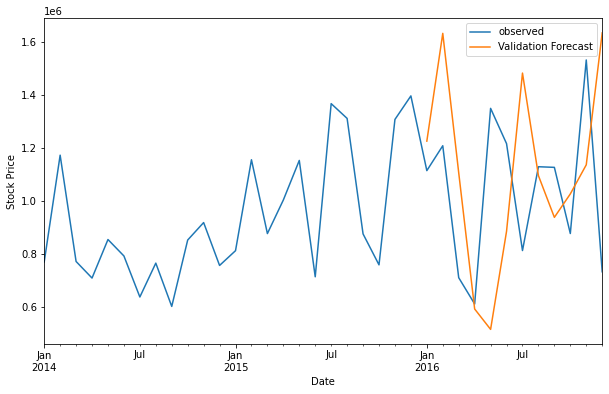

In [79]:
pred = model.get_prediction(start=pd.to_datetime('2016-01-31'))
#pred = model.get_forecast(steps=12)

plt.figure(figsize=(10,6))
ax = y['2014':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='Validation Forecast')
ax.set_xlabel('Date')
ax.set_ylabel('Stock Price')
plt.legend()
plt.show()

#### Here we can see a huge difference between observed & validation forecast so this model is not fit for the prediction

## Using LSTM

#### Heatmap

<AxesSubplot:>

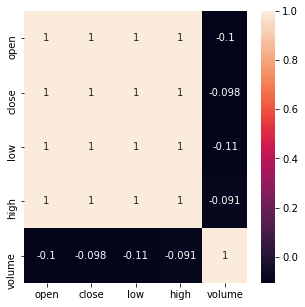

In [23]:
cormap = df.corr()
fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(cormap, annot = True)

In [24]:
df1=df.reset_index()['close']
df1.shape

(1762,)

In [25]:
df1

0        40.380001
1        40.139999
2        40.490002
3        40.480000
4        40.639999
           ...    
1757    170.889999
1758    171.839996
1759    170.419998
1760    170.279999
1761    169.119995
Name: close, Length: 1762, dtype: float64

## Using LSTM

#### LSTM are sensitive to the scale of the data. so we apply MinMax scaler

In [26]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))
df1.shape

(1762, 1)

In [27]:
#Splitting the dataset into train & test data
training_size=int(len(df1)*0.70)
test_size=len(df1)-training_size
train_data,test_data=df1[0:training_size,:],df1[training_size:len(df1),:1]
training_size,test_size

(1233, 529)

In [28]:
print(df1)

[[0.00756731]
 [0.00607864]
 [0.00824961]
 ...
 [0.81416694]
 [0.81329857]
 [0.80610341]]


In [29]:
#Convert an array of values into dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY= [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i+ time_step, 0])
    return np.array(dataX), np.array(dataY)

In [30]:
#reshape into X=t, t+1, t+2, t+3 and Y=t+4
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)
print(X_train)

[[0.00756731 0.00607864 0.00824961 ... 0.06444609 0.07362609 0.06847786]
 [0.00607864 0.00824961 0.00818757 ... 0.07362609 0.06847786 0.07548692]
 [0.00824961 0.00818757 0.00918    ... 0.06847786 0.07548692 0.07815406]
 ...
 [0.59397094 0.59155189 0.58981514 ... 0.65531568 0.66164247 0.6641856 ]
 [0.59155189 0.58981514 0.59409502 ... 0.66164247 0.6641856  0.65488154]
 [0.58981514 0.59409502 0.58826447 ... 0.6641856  0.65488154 0.65767274]]


In [31]:
print(X_train.shape), print(y_train.shape)

(1132, 100)
(1132,)


(None, None)

In [32]:
print(X_test.shape), print(y_test.shape)

(428, 100)
(428,)


(None, None)

In [33]:
# Reshape input to be [samples, time steps, features] which is required for LSTM
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1], 1)

In [34]:
# Create the stacked LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [36]:
model=Sequential()
model.add(LSTM(50,return_sequences=True, input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 100, 50)           10400     
_________________________________________________________________
lstm_4 (LSTM)                (None, 100, 50)           20200     
_________________________________________________________________
lstm_5 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [37]:
X_train[:100]

array([[[0.00756731],
        [0.00607864],
        [0.00824961],
        ...,
        [0.06444609],
        [0.07362609],
        [0.06847786]],

       [[0.00607864],
        [0.00824961],
        [0.00818757],
        ...,
        [0.07362609],
        [0.06847786],
        [0.07548692]],

       [[0.00824961],
        [0.00818757],
        [0.00918   ],
        ...,
        [0.06847786],
        [0.07548692],
        [0.07815406]],

       ...,

       [[0.06444609],
        [0.07362609],
        [0.06847786],
        ...,
        [0.12473638],
        [0.12839598],
        [0.1291403 ]],

       [[0.07362609],
        [0.06847786],
        [0.07548692],
        ...,
        [0.12839598],
        [0.1291403 ],
        [0.12796179]],

       [[0.06847786],
        [0.07548692],
        [0.07815406],
        ...,
        [0.1291403 ],
        [0.12796179],
        [0.13521895]]])

In [38]:
model.fit(X_train, y_train,validation_data=(X_test,y_test),epochs=100,batch_size=64, verbose=1)

Epoch 1/100
18/18 [==============================] - 14s 363ms/step - loss: 0.0232 - val_loss: 0.0262
Epoch 2/100
18/18 [==============================] - 5s 263ms/step - loss: 0.0018 - val_loss: 0.0087
Epoch 3/100
18/18 [==============================] - 5s 259ms/step - loss: 7.9840e-04 - val_loss: 0.0030
Epoch 4/100
18/18 [==============================] - 5s 266ms/step - loss: 6.5095e-04 - val_loss: 0.0030
Epoch 5/100
18/18 [==============================] - 5s 271ms/step - loss: 6.0641e-04 - val_loss: 0.0033
Epoch 6/100
18/18 [==============================] - 5s 253ms/step - loss: 6.0161e-04 - val_loss: 0.0029
Epoch 7/100
18/18 [==============================] - 5s 257ms/step - loss: 6.0322e-04 - val_loss: 0.0028
Epoch 8/100
18/18 [==============================] - 5s 257ms/step - loss: 6.4774e-04 - val_loss: 0.0038
Epoch 9/100
18/18 [==============================] - 5s 264ms/step - loss: 6.2882e-04 - val_loss: 0.0026
Epoch 10/100
18/18 [==============================] - 5s 269ms

In [39]:
import tensorflow as tf

In [40]:
# Lets do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

In [41]:
# Transform back to original form
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

In [42]:
# Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

87.11364401277464

In [43]:
#test data RMSE
math.sqrt(mean_squared_error(y_test, test_predict))

161.42293439528274

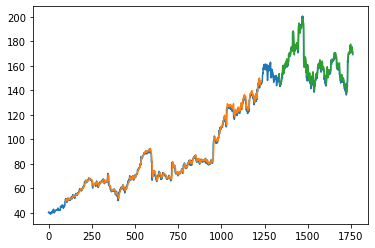

In [44]:
# Plotting
# Shift train prediction for plotting
look_back=100
trainPredictPlot = np.empty_like(df1)
trainPredictPlot[:, :]= np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :]= train_predict
# Shift test prediction for plotting
testPredictPlot = np.empty_like(df1)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] =test_predict
# Plot baseline and Predictions
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [45]:
len(test_data)

529

In [46]:
x_input=test_data[429:].reshape(1,-1)
x_input.shape

(1, 100)

In [48]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()
len(temp_input)

100

In [49]:
# Demonstrate prediction for next 10 days
from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<30):
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input= x_input.reshape((1, n_steps, 1))
        # Print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} Day Output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        # Print (temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
print(lst_output)

[0.8127434]
101
1 day input [0.79115496 0.786751   0.79766773 0.75201582 0.73743952 0.73359378
 0.73737743 0.74004464 0.73675722 0.75176775 0.75065122 0.72987221
 0.73508246 0.72881777 0.73328372 0.74184339 0.74066495 0.75040315
 0.76119589 0.74252569 0.70586778 0.70841081 0.69482688 0.69197369
 0.68093288 0.67578463 0.67783153 0.66201461 0.66474382 0.6822354
 0.68279371 0.68812804 0.69377243 0.68130503 0.66728695 0.68204932
 0.66852747 0.66604633 0.6808708  0.67950629 0.67590871 0.67547447
 0.66741094 0.67485426 0.66753502 0.66666664 0.64576356 0.64402681
 0.6393127  0.63354422 0.63745187 0.6323037  0.64911298 0.65004344
 0.62064259 0.62672121 0.62597692 0.62417808 0.61394365 0.61834762
 0.6018484  0.61022199 0.61102838 0.62752759 0.66158047 0.65661829
 0.6434685  0.7763925  0.76801881 0.78873591 0.76547577 0.7923334
 0.81336056 0.81801258 0.81689615 0.81633792 0.81032129 0.80982506
 0.81627584 0.81243019 0.81484924 0.83209275 0.85361614 0.85200347
 0.84617292 0.83016993 0.82316084 0.

In [50]:
import matplotlib.pyplot as plt
day_new=np.arange(1,101)
day_pred=np.arange(101,131)
len(df1)

1762

In [51]:
df3=df1.tolist()
df3.extend(lst_output)

#### Here we are going to finalize LSTM model for forcasting as we are getting 86.70% Accuracy.

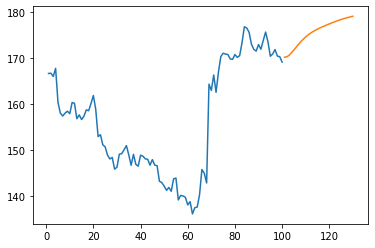

In [52]:
plt.plot(day_new,scaler.inverse_transform(df1[1662:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))

## Final Conclusion: LSTM model is best for the prediction of given data set.